

```
# This is formatted as code
```

## Import Libraries

In [148]:
import numpy as np
import tensorflow as tf
import pandas as pd
pd.options.mode.chained_assignment = None
import seaborn as sns
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

%matplotlib inline

sns.set(style='whitegrid', palette='muted')
rcParams['figure.figsize'] = 14, 8
np.random.seed(1)
tf.random.set_seed(1)

print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.4.0


## Load and Inspect the Nifty50 Index Data

In [149]:
df = pd.read_csv('/content/NIFTY50.csv' , parse_dates = ['date'])
df.head()

,date,close
0,1994-01-03,1083.74
1,1994-01-04,1091.81
2,1994-01-05,1082.80
3,1994-01-06,1098.91
4,1994-01-07,1146.31


In [150]:
df.shape

(6670, 2)

In [151]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.date , y = df.close , mode = 'lines' , name = 'close'))
fig.update_layout(showlegend = True)
fig.show()

## Data Preprocessing

In [152]:
train_size = int(len(df)*0.95)
test_size = len(df) - train_size 
train , test = df.iloc[0:train_size] , df.iloc[train_size:len(df)]
print(train.shape , test.shape)

(6336, 2) (334, 2)


In [153]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler=scaler.fit(train[['close']])
train['close'] = scaler.transform(train[['close']])
test['close'] = scaler.transform(test[['close']])

## Create Training and Test Splits

In [154]:
def create_sequences (X,y,time_step=30):
    Xs , ys = [],[]
    for i in range(len(X) - time_steps):
        Xs.append(X.iloc[i:(i+time_steps)].values)
        ys.append(y.iloc[i+time_steps])
    return np.array(Xs) , np.array(ys)

In [155]:
time_steps = 30
X_train , y_train = create_sequences(train[['close']] , train.close , time_steps)
X_test , y_test = create_sequences(test[['close']] , test.close , time_steps)
print(X_train.shape)

(6306, 30, 1)


## Build an LSTM Autoencoder

In [156]:
timesteps = X_train.shape[1]
num_features = X_train.shape[2]

In [157]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

model = Sequential([LSTM(128 , input_shape=(timesteps , num_features)),Dropout(0.5),RepeatVector(timesteps),LSTM(128,return_sequences=True),Dropout(0.5),TimeDistributed(Dense(num_features))])

model.compile(loss='mae' , optimizer='adam')

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 30, 128)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 30, 128)           131584    
_________________________________________________________________
dropout_5 (Dropout)          (None, 30, 128)           0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 1)             129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
________________________________________________

## Train the Autoencoder

In [158]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss' , patience = 3 , mode='min')
history = model.fit(X_train,y_train,epochs=10,batch_size=128,validation_split=0.20,callbacks=[es],shuffle=False)

Epoch 1/10
40/40 [==============================] - 3s 26ms/step - loss: 0.3867 - val_loss: 0.2322
Epoch 2/10
40/40 [==============================] - 0s 8ms/step - loss: 0.2479 - val_loss: 0.2122
Epoch 3/10
40/40 [==============================] - 0s 8ms/step - loss: 0.1256 - val_loss: 0.1683
Epoch 4/10
40/40 [==============================] - 0s 8ms/step - loss: 0.1350 - val_loss: 0.1294
Epoch 5/10
40/40 [==============================] - 0s 8ms/step - loss: 0.2049 - val_loss: 0.1575
Epoch 6/10
40/40 [==============================] - 0s 8ms/step - loss: 0.1254 - val_loss: 0.1736
Epoch 7/10
40/40 [==============================] - 0s 8ms/step - loss: 0.1402 - val_loss: 0.1365


## Plot Metrics and Evaluate the Model

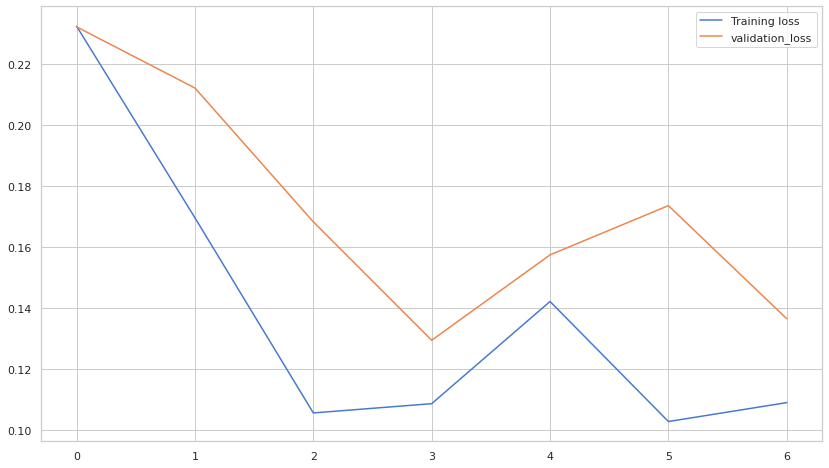

In [159]:
plt.plot(history.history['loss'],label='Training loss')
plt.plot(history.history['val_loss'],label='validation_loss')
plt.legend()

In [160]:
X_train_pred = model.predict(X_train)

train_mae_loss = pd.DataFrame(np.mean(np.abs(X_train_pred-X_train),axis = 1),columns = ['Error'])

In [161]:
model.evaluate(X_test,y_test)

10/10 [==============================] - 0s 3ms/step - loss: 0.2287


0.22873973846435547

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



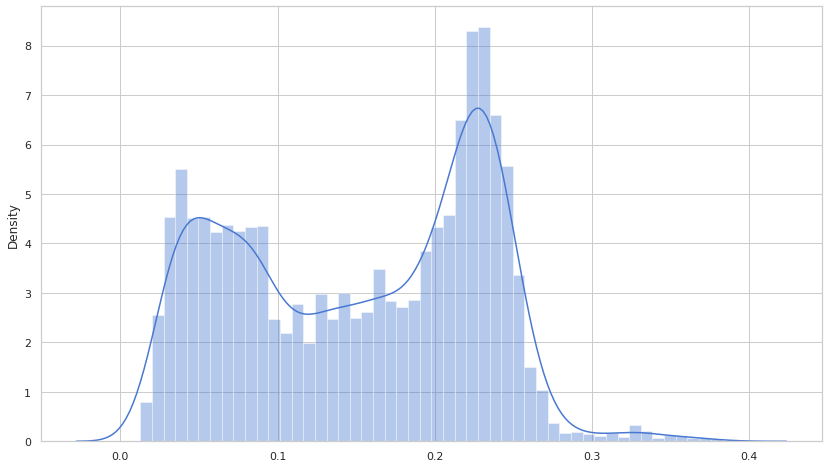

In [162]:
sns.distplot(train_mae_loss , bins = 50 , kde= True)

In [171]:
threshold = 0.38

In [172]:
X_test_pred = model.predict(X_test)
test_mae_loss = np.mean(np.abs(X_test_pred - X_test),axis=1)

## Detect Anomalies in the Nifty50 Index Data

In [173]:
test_score_df = pd.DataFrame(test[time_steps:])
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = threshold
test_score_df['anamoly'] = test_score_df.loss > test_score_df.threshold
test_score_df['close'] = test[time_steps:].close

In [174]:
test_score_df.head()

,date,close,loss,threshold,anamoly
6366,2019-10-24,2.330679,0.322161,0.38,False
6367,2019-10-25,2.331084,0.320898,0.38,False
6368,2019-10-27,2.344561,0.317682,0.38,False
6369,2019-10-29,2.394325,0.315588,0.38,False
6370,2019-10-30,2.412164,0.329055,0.38,False


In [175]:
test_score_df.tail()

,date,close,loss,threshold,anamoly
6665,2021-01-04,3.125371,0.500192,0.38,True
6666,2021-01-05,3.146124,0.512002,0.38,True
6667,2021-01-06,3.129531,0.525897,0.38,True
6668,2021-01-07,3.126757,0.527795,0.38,True
6669,2021-01-08,3.192164,0.525998,0.38,True


In [176]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = test[time_steps:].date, y = test_score_df.loss,mode='lines',name='Test_Loss'))
fig.add_trace(go.Scatter(x = test[time_steps:].date, y = test_score_df.threshold,mode='lines',name='Threshold'))
fig.update_layout(showlegend = True)
fig.show()

In [177]:
anomalies = test_score_df[test_score_df.anamoly == True]
anomalies

,date,close,loss,threshold,anamoly
6466,2020-03-17,1.515655,0.466137,0.38,True
6467,2020-03-18,1.360397,0.554257,0.38,True
6468,2020-03-19,1.296408,0.656142,0.38,True
6469,2020-03-20,1.446603,0.736983,0.38,True
6470,2020-03-23,1.092866,0.729956,0.38,True
6471,2020-03-24,1.152321,0.820319,0.38,True
6472,2020-03-25,1.313359,0.852374,0.38,True
6473,2020-03-26,1.414196,0.808540,0.38,True
6474,2020-03-27,1.420054,0.729619,0.38,True
6475,2020-03-30,1.301908,0.656549,0.38,True


In [178]:
fig = go.Figure()
fig.add_trace(go.Scatter(x = test[time_steps:].date, y = scaler.inverse_transform(test[time_steps:].close),mode='lines',name='Close Price'))
fig.add_trace(go.Scatter(x = anomalies.date, y = scaler.inverse_transform(anomalies.close),mode='markers',name='Anomalies'))
fig.update_layout(showlegend = True)
fig.show()